ссылка на датасет: https://www.kaggle.com/datasets/ankurnapa/brewery-operations-and-market-analysis-dataset/data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, collect_list
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from hyperopt import fmin, tpe, hp, Trials
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [2]:
session = SparkSession.builder.appName('whatisanappname').getOrCreate()

In [3]:
data = session.read.csv("brewery_data_complete_extended.csv", header=True, inferSchema=True)

In [4]:
data.head(5)

[Row(Batch_ID=7870796, Brew_Date=datetime.datetime(2020, 1, 1, 0, 0, 19), Beer_Style='Wheat Beer', SKU='Kegs', Location='Whitefield', Fermentation_Time=16, Temperature=24.204250857069873, pH_Level=5.2898454476095615, Gravity=1.0395041267301979, Alcohol_Content=5.370842159553436, Bitterness=20, Color=5, Ingredient_Ratio='1:0.32:0.16', Volume_Produced=4666, Total_Sales=2664.7593448382822, Quality_Score=8.57701633109399, Brewhouse_Efficiency=89.19588216376087, Loss_During_Brewing=4.1049876591878345, Loss_During_Fermentation=3.2354851724654683, Loss_During_Bottling_Kegging=4.663204448186049),
 Row(Batch_ID=9810411, Brew_Date=datetime.datetime(2020, 1, 1, 0, 0, 31), Beer_Style='Sour', SKU='Kegs', Location='Whitefield', Fermentation_Time=13, Temperature=18.086762947259544, pH_Level=5.275643382756193, Gravity=1.0598189516987164, Alcohol_Content=5.096053082797625, Bitterness=36, Color=14, Ingredient_Ratio='1:0.39:0.24', Volume_Produced=832, Total_Sales=9758.801062471319, Quality_Score=7.420540

In [5]:
data.printSchema()

root
 |-- Batch_ID: integer (nullable = true)
 |-- Brew_Date: timestamp (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Fermentation_Time: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: integer (nullable = true)
 |-- Color: integer (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Volume_Produced: integer (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)



In [6]:
data.describe()

DataFrame[summary: string, Batch_ID: string, Beer_Style: string, SKU: string, Location: string, Fermentation_Time: string, Temperature: string, pH_Level: string, Gravity: string, Alcohol_Content: string, Bitterness: string, Color: string, Ingredient_Ratio: string, Volume_Produced: string, Total_Sales: string, Quality_Score: string, Brewhouse_Efficiency: string, Loss_During_Brewing: string, Loss_During_Fermentation: string, Loss_During_Bottling_Kegging: string]

In [5]:
cols = data.select("Beer_Style").distinct()

In [8]:
cols.show()

+----------+
|Beer_Style|
+----------+
|    Porter|
|      Sour|
|     Lager|
|Wheat Beer|
|   Pilsner|
|       Ale|
|     Stout|
|       IPA|
+----------+



In [6]:
data = data.drop("Batch_ID")

In [10]:
data.head(5)

[Row(Brew_Date=datetime.datetime(2020, 1, 1, 0, 0, 19), Beer_Style='Wheat Beer', SKU='Kegs', Location='Whitefield', Fermentation_Time=16, Temperature=24.204250857069873, pH_Level=5.2898454476095615, Gravity=1.0395041267301979, Alcohol_Content=5.370842159553436, Bitterness=20, Color=5, Ingredient_Ratio='1:0.32:0.16', Volume_Produced=4666, Total_Sales=2664.7593448382822, Quality_Score=8.57701633109399, Brewhouse_Efficiency=89.19588216376087, Loss_During_Brewing=4.1049876591878345, Loss_During_Fermentation=3.2354851724654683, Loss_During_Bottling_Kegging=4.663204448186049),
 Row(Brew_Date=datetime.datetime(2020, 1, 1, 0, 0, 31), Beer_Style='Sour', SKU='Kegs', Location='Whitefield', Fermentation_Time=13, Temperature=18.086762947259544, pH_Level=5.275643382756193, Gravity=1.0598189516987164, Alcohol_Content=5.096053082797625, Bitterness=36, Color=14, Ingredient_Ratio='1:0.39:0.24', Volume_Produced=832, Total_Sales=9758.801062471319, Quality_Score=7.420540752553908, Brewhouse_Efficiency=72.4

In [7]:
data = data.withColumn("Ingredient_A", split(data["Ingredient_Ratio"], ":")[0].cast("double"))
data = data.withColumn("Ingredient_B", split(data["Ingredient_Ratio"], ":")[1].cast("double"))
data = data.withColumn("Ingredient_C", split(data["Ingredient_Ratio"], ":")[2].cast("double"))
data = data.drop("Ingredient_Ratio")

In [12]:
data.printSchema()

root
 |-- Brew_Date: timestamp (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Fermentation_Time: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: integer (nullable = true)
 |-- Color: integer (nullable = true)
 |-- Volume_Produced: integer (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)
 |-- Ingredient_A: double (nullable = true)
 |-- Ingredient_B: double (nullable = true)
 |-- Ingredient_C: double (nullable = true)



In [13]:
data.head(5)

[Row(Brew_Date=datetime.datetime(2020, 1, 1, 0, 0, 19), Beer_Style='Wheat Beer', SKU='Kegs', Location='Whitefield', Fermentation_Time=16, Temperature=24.204250857069873, pH_Level=5.2898454476095615, Gravity=1.0395041267301979, Alcohol_Content=5.370842159553436, Bitterness=20, Color=5, Volume_Produced=4666, Total_Sales=2664.7593448382822, Quality_Score=8.57701633109399, Brewhouse_Efficiency=89.19588216376087, Loss_During_Brewing=4.1049876591878345, Loss_During_Fermentation=3.2354851724654683, Loss_During_Bottling_Kegging=4.663204448186049, Ingredient_A=1.0, Ingredient_B=0.32, Ingredient_C=0.16),
 Row(Brew_Date=datetime.datetime(2020, 1, 1, 0, 0, 31), Beer_Style='Sour', SKU='Kegs', Location='Whitefield', Fermentation_Time=13, Temperature=18.086762947259544, pH_Level=5.275643382756193, Gravity=1.0598189516987164, Alcohol_Content=5.096053082797625, Bitterness=36, Color=14, Volume_Produced=832, Total_Sales=9758.801062471319, Quality_Score=7.420540752553908, Brewhouse_Efficiency=72.480915390

In [8]:
beer_style_encoder = StringIndexer(inputCol="Beer_Style", outputCol="Beer_Style_Encoded")
container_encoder = StringIndexer(inputCol="SKU", outputCol="Container_Encoded")
location_encoder = StringIndexer(inputCol="Location", outputCol="Location_Encoded")

In [9]:
data = beer_style_encoder.fit(data).transform(data)
data = container_encoder.fit(data).transform(data)
data = location_encoder.fit(data).transform(data)

In [10]:
data = data.drop(*["Beer_Style", "SKU", "Location"])

In [17]:
data.show()

+-------------------+-----------------+------------------+------------------+------------------+-----------------+----------+-----+---------------+------------------+-----------------+--------------------+-------------------+------------------------+----------------------------+------------+------------+------------+------------------+-----------------+----------------+
|          Brew_Date|Fermentation_Time|       Temperature|          pH_Level|           Gravity|  Alcohol_Content|Bitterness|Color|Volume_Produced|       Total_Sales|    Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|Ingredient_A|Ingredient_B|Ingredient_C|Beer_Style_Encoded|Container_Encoded|Location_Encoded|
+-------------------+-----------------+------------------+------------------+------------------+-----------------+----------+-----+---------------+------------------+-----------------+--------------------+-------------------+------------------------+----

In [11]:
columns = list(filter(lambda x: x!="Brew_Date", data.columns))

In [19]:
columns

['Fermentation_Time',
 'Temperature',
 'pH_Level',
 'Gravity',
 'Alcohol_Content',
 'Bitterness',
 'Color',
 'Volume_Produced',
 'Total_Sales',
 'Quality_Score',
 'Brewhouse_Efficiency',
 'Loss_During_Brewing',
 'Loss_During_Fermentation',
 'Loss_During_Bottling_Kegging',
 'Ingredient_A',
 'Ingredient_B',
 'Ingredient_C',
 'Beer_Style_Encoded',
 'Container_Encoded',
 'Location_Encoded']

In [20]:
assembler = VectorAssembler(inputCols=columns, outputCol="features")
data_assembled = assembler.transform(data)

In [21]:
corr_matrix = Correlation.corr(data_assembled, "features", method='pearson').head()

In [22]:
corr_matrix

Row(pearson(features)=DenseMatrix(20, 20, [1.0, 0.0002, 0.0001, 0.0003, 0.0001, -0.0001, -0.0, -0.0001, ..., -0.0003, -0.0003, nan, 0.0001, -0.0003, 0.0003, -0.0004, 1.0], False))

In [23]:
corr_matrix_array = corr_matrix[0].toArray()

In [24]:
pd_corr_matrix = pd.DataFrame(corr_matrix_array, columns=columns, index=columns)

<Axes: >

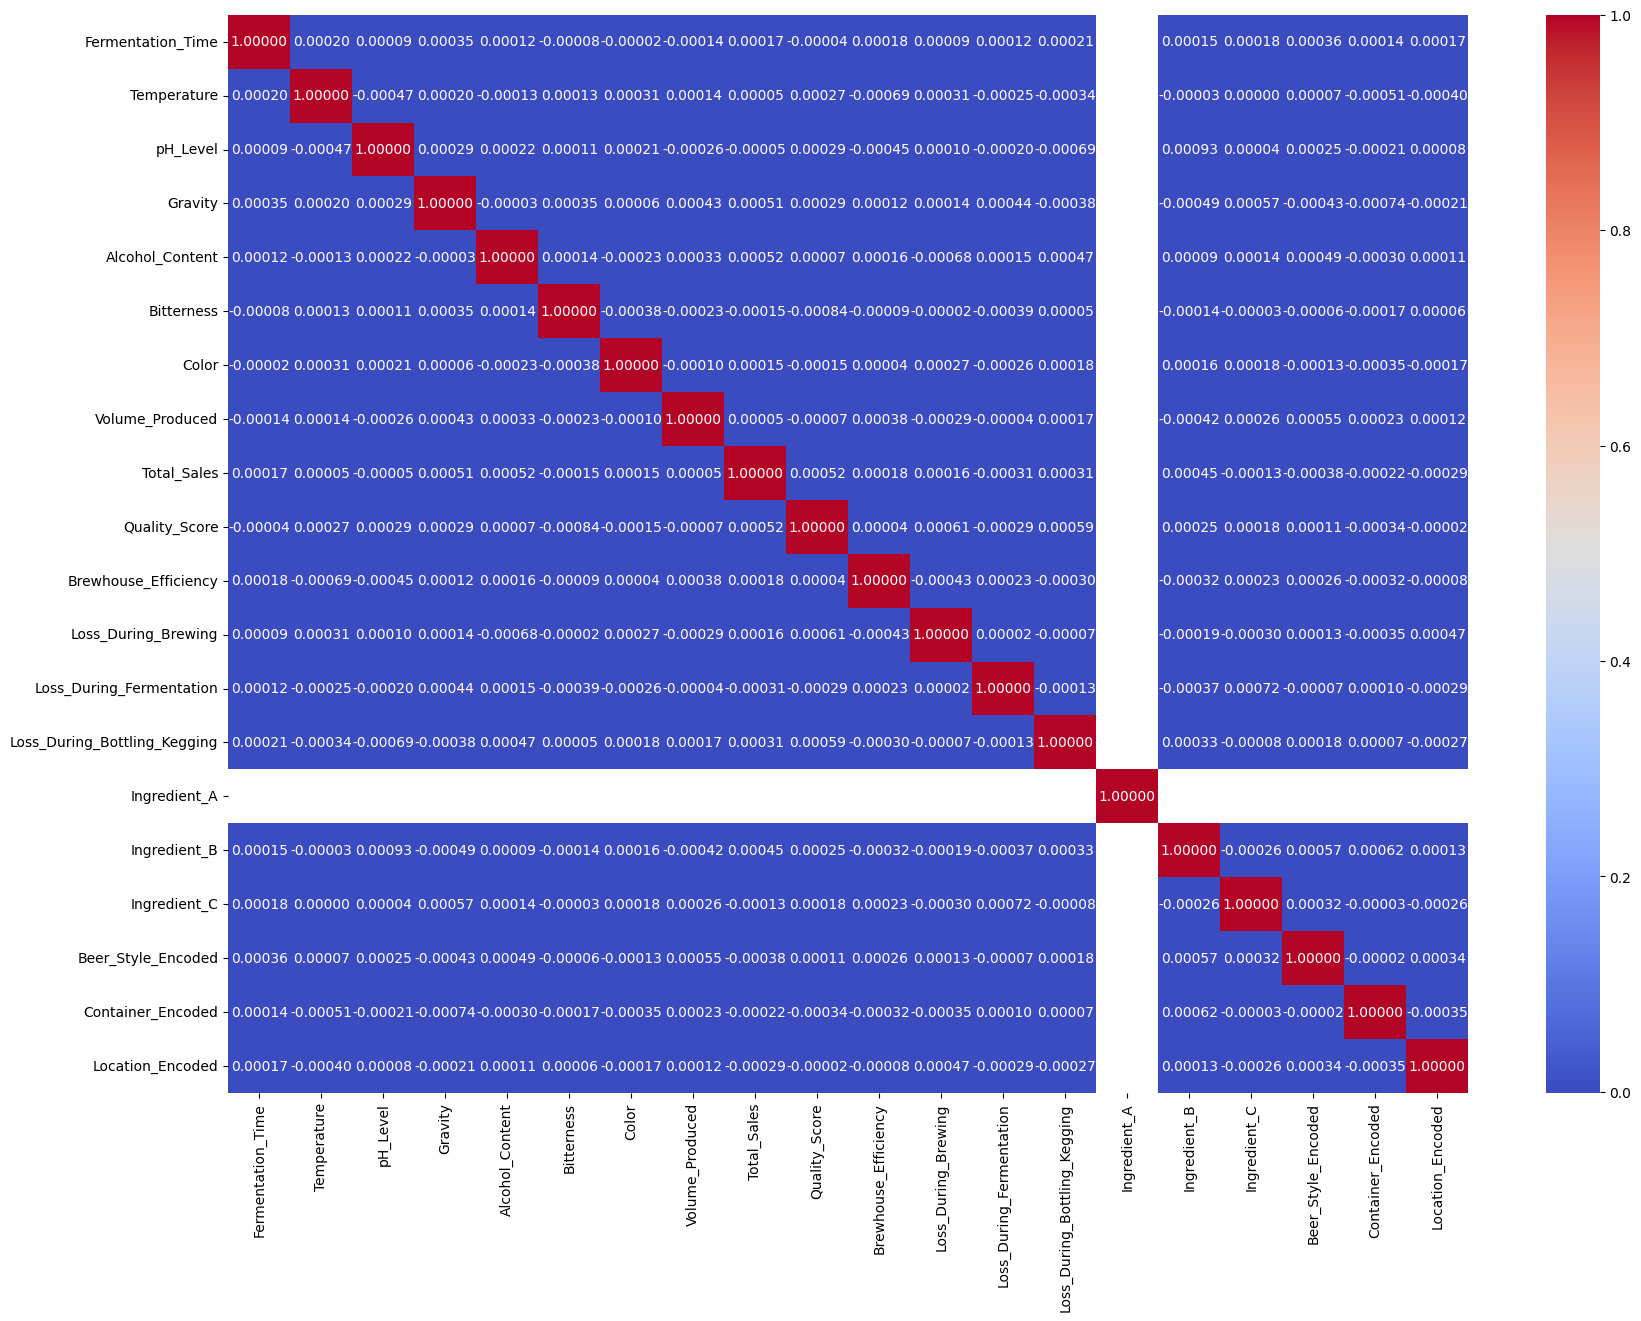

In [79]:
plt.figure(figsize=(20,14))
sns.heatmap(pd_corr_matrix, annot=True, cmap="coolwarm", fmt=".5f")

In [26]:
missing_values = data.select([col(c).isNull().alias(c) for c in columns])

In [40]:
missing_values.show()

+-----------------+-----------+--------+-------+---------------+----------+-----+---------------+-----------+-------------+--------------------+-------------------+------------------------+----------------------------+------------+------------+------------+------------------+-----------------+----------------+
|Fermentation_Time|Temperature|pH_Level|Gravity|Alcohol_Content|Bitterness|Color|Volume_Produced|Total_Sales|Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|Ingredient_A|Ingredient_B|Ingredient_C|Beer_Style_Encoded|Container_Encoded|Location_Encoded|
+-----------------+-----------+--------+-------+---------------+----------+-----+---------------+-----------+-------------+--------------------+-------------------+------------------------+----------------------------+------------+------------+------------+------------------+-----------------+----------------+
|            false|      false|   false|  false|          false|

In [43]:
true_counts = {}
for column in missing_values.columns:
    true_count = missing_values.select(col(column).cast("int")).agg({column: "sum"}).collect()[0][f"sum({column})"]
    true_counts[column] = true_count

In [48]:
true_counts

{'Fermentation_Time': 0,
 'Temperature': 0,
 'pH_Level': 0,
 'Gravity': 0,
 'Alcohol_Content': 0,
 'Bitterness': 0,
 'Color': 0,
 'Volume_Produced': 0,
 'Total_Sales': 0,
 'Quality_Score': 0,
 'Brewhouse_Efficiency': 0,
 'Loss_During_Brewing': 0,
 'Loss_During_Fermentation': 0,
 'Loss_During_Bottling_Kegging': 0,
 'Ingredient_A': 0,
 'Ingredient_B': 0,
 'Ingredient_C': 0,
 'Beer_Style_Encoded': 0,
 'Container_Encoded': 0,
 'Location_Encoded': 0}

In [49]:
len(columns)

20

Заполнение строки: 100%|██████████| 5/5 [08:48<00:00, 105.66s/iteration]


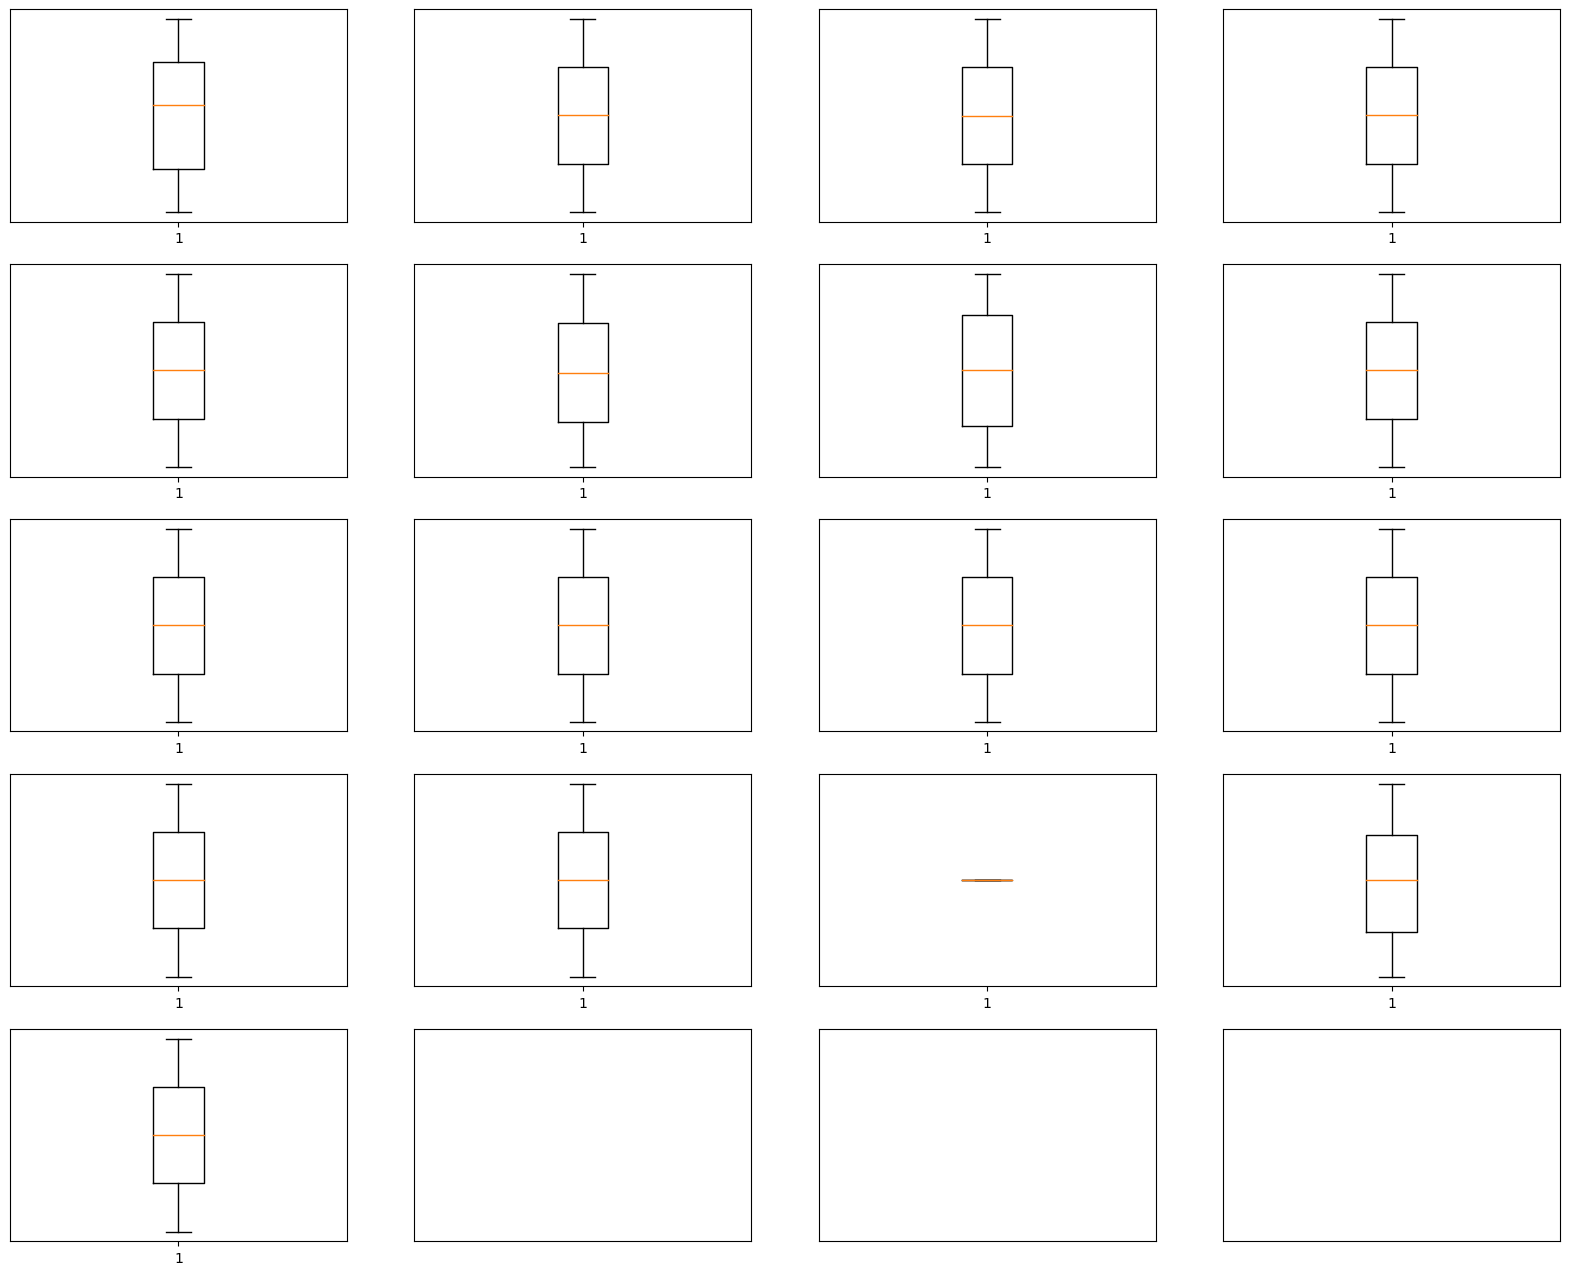

In [73]:
fig, axis = plt.subplots(nrows = 5, ncols = 4, figsize=(20,16))
for r_axis in axis:
    for ax in r_axis:
        ax.set_xticks([])
        ax.set_yticks([])
k = 0

for i in tqdm(range(5), desc="Заполнение строки", unit="iteration", position=0):
    for j in tqdm(range(4), desc="Заполнение стобцов строки", unit="iteration", position=1):
        column_data = data.agg(collect_list(columns[k])).first()[0]
        if k > 16: continue
        axis[i][j].boxplot(column_data)
        k+=1

In [12]:
train, val, test = data.randomSplit([0.7,0.1,0.2], seed=42)

In [21]:
train.count()

7000725

In [13]:
columns_ = list(filter(lambda x: x!="Total_Sales", columns))

In [14]:
columns_

['Fermentation_Time',
 'Temperature',
 'pH_Level',
 'Gravity',
 'Alcohol_Content',
 'Bitterness',
 'Color',
 'Volume_Produced',
 'Quality_Score',
 'Brewhouse_Efficiency',
 'Loss_During_Brewing',
 'Loss_During_Fermentation',
 'Loss_During_Bottling_Kegging',
 'Ingredient_A',
 'Ingredient_B',
 'Ingredient_C',
 'Beer_Style_Encoded',
 'Container_Encoded',
 'Location_Encoded']

In [15]:
assembler = VectorAssembler(inputCols=columns_, outputCol="features")
data_assembled_train = assembler.transform(train)
data_assembled_val = assembler.transform(val)
data_assembled_test = assembler.transform(test)

In [16]:
rf_regressor = RandomForestRegressor(
        labelCol="Total_Sales",
        featuresCol="features",
        maxDepth=20,
        maxBins=32,
        seed=42,
        numTrees=20,
    )

In [18]:
rf_regressor.fit(data_assembled_train)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "c:\Users\HAWK\AppData\Local\Programs\Python\Python311\Lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HAWK\AppData\Local\Programs\Python\Python311\Lib\socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] Удаленный хост принудительно разорвал существующее подключение

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\HAWK\AppData\Local\Programs\Python\Python311\Lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HAWK\AppData\Local\Programs\Python\Python311\Lib\site-packages\py4j\

Py4JError: An error occurred while calling o235.fit

In [27]:
def rf_regressor_scoring(params):
    rf_regressor = RandomForestRegressor(
        labelCol="Total_Sales",
        featuresCol="features",
        maxDepth=int(params['maxDepth']),
        maxBins=params['maxBins'],
        seed=42,
        numTrees=params['numTrees'],
    )
    grid = ParamGridBuilder().build()
    rg_evaluator = RegressionEvaluator(metricName="rmse", predictionCol="Total_Sales")
    cv = CrossValidator(estimator=rf_regressor, estimatorParamMaps=grid, evaluator=rg_evaluator, numFolds=5, seed=42, parallelism=1)
    
    model = cv.fit(data_assembled_train)
    rmse = rg_evaluator.evaluate(model.transform(data_assembled_val))

    return rmse

In [28]:
space = {
    'numTrees' : hp.choice('numTrees', range(100,1000)),
    'maxDepth' : hp.choice('maxDepth', range(5,20)),
    'maxBins': hp.choice('maxBins', range(32,128))
}

In [29]:
best = fmin(
    fn=rf_regressor_scoring,
    space=space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials())

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

job exception: An error occurred while calling o300.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 6 in stage 18.0 failed 1 times, most recent failure: Lost task 6.0 in stage 18.0 (TID 115) (DESKTOP-V4OEA2B executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:71)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:374)
	at org.apache.spark.sql.execution.columnar.BasicColumnBuilder.build(ColumnBuilder.scala:81)
	at org.apache.spark.sql.execution.columnar.ComplexColumnBuilder.org$apache$spark$sql$execution$columnar$NullableColumnBuilder$$super$build(ColumnBuilder.scala:93)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.build(NullableColumnBuilder.scala:67)
	at org.apache.spark.sql.execution.columnar.NullableColumnBuilder.build$(NullableColumnBuilder.scala:66)
	at org.apache.spark.sql.execution.columnar.ComplexColumnBuilder.build(ColumnBuilder.scala:93)
	at o

  0%|          | 0/10 [00:14<?, ?trial/s, best loss=?]


ConnectionRefusedError: [WinError 10061] Подключение не установлено, т.к. конечный компьютер отверг запрос на подключение

Не знаю что писать в выводах, ибо по факту половина функционала просто отваливалась и я ловил **Py4JError**, а после чего ложился сервер. Данные оказались практически полностью обработанными в том плане, что потребовалось лишь закодировать категориальные признаки. Выбросов в данных нет и возможно по той причине, что автор данных их не добавлял(данные синтетические). Я пытался обучить RFR что через hyperopt, что вручную, но ждать по 4 минуты, а потом получать **Py4JError** и отвалившийся сервер я устал.